### Base Experiments of Knowledge Distillation

In [1]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
import time
import tqdm
from tqdm import tqdm_notebook
from collections import OrderedDict, defaultdict

###  1. Hinton + L2-penalization of parameters

In [2]:
# Own exceptions that deal with the AssertionError
class BaseValidationError(TypeError):
    pass
class NumInputMLPWrong(BaseValidationError):
    pass
class HiddenLayersMLPWrong(BaseValidationError):
    pass
class NumClassesMLPWrong(BaseValidationError):
    pass

In [3]:
# Create decorator to avoid repeating of a code
def own_assertionerror_exception(function):
    
    """
    function: decorator will be applied to this function(__init__)
    *args: passes variable of function
    **kwargs: keyworded variable of function
    
    """
    def wrapper(*args, **kwargs):
        
        for idx, keys, types, exception in zip( range(1,4),['num_input','hidden_layers','num_classes'],[int,list,int], 
                                         [NumInputMLPWrong, HiddenLayersMLPWrong, NumClassesMLPWrong ]):
            if keys in kwargs.keys():
                if isinstance(kwargs[keys],types) == False:
                    raise exception
            
            else:
                if isinstance(args[idx],types) ==  False:
                    raise exception
        
        result = function(*args,**kwargs)
        return result
    
    return wrapper
        

In [13]:
class SimpleConvNet(torch.nn.Module):
  def __new__(cls, num_classes):
    return torch.nn.Sequential(OrderedDict([
        ("layer_1",torch.nn.Conv2d(3,128,7, bias=False)),
        ("bn_1", torch.nn.BatchNorm2d(128)),
        ("relu_1", torch.nn.ReLU()),
        ("max_pool", torch.nn.MaxPool2d(2)),
        ("layer_2", torch.nn.Conv2d(128,256,5,bias=False)),
        ("bn_2", torch.nn.BatchNorm2d(256)),
        ("relu_2", torch.nn.ReLU()),
        ("layer_3",torch.nn.Conv2d(256,256,5, bias=False)),
        ("bn_3", torch.nn.BatchNorm2d(256)),
        ("relu_3", torch.nn.ReLU()),
        
        ("flatten", torch.nn.Flatten()),
        ("linear_1", torch.nn.Linear(256*5*5,512)),
        ("relu_4", torch.nn.ReLU()),
        
        ("linear_2", torch.nn.Linear(512, num_classes))]))

In [5]:
def plot_learning_curves(history,num_epoch):
    '''
     
    This function is aimed to show up at all loss and accuracy (metrics) during the training of the model

    :param history: (dict)
        accuracy and loss on the training and validation
    '''
    # sns.set_style(style='whitegrid')

    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)

      
    plt.fill_between(np.arange(1,num_epoch + 2),(np.mean(history['loss']['train'], axis = 1 ) - np.std(history['loss']['train'],axis = 1)),\
                     (np.mean(history['loss']['train'],axis = 1  ) + np.std(history['loss']['train'],axis = 1)), label='train',alpha=.5)
     
    plt.fill_between(np.arange(1,num_epoch + 2),(np.mean(history['loss']['val'],axis=1 ) - np.std(history['loss']['val'],axis=1)),\
                     (np.mean(history['loss']['val'],axis= 1 ) + np.std(history['loss']['val'],axis= 1)), label='validation',alpha=.5)

    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    
    plt.fill_between(np.arange(1,num_epoch + 2),(np.mean(history['acc']['train'],axis=1) - np.std(history['acc']['train'],axis=1)),\
                     (np.mean(history['acc']['train'],axis=1 ) + np.std(history['acc']['train'],axis=1)), label='train',alpha=.5)
    
    plt.fill_between(np.arange(1,num_epoch + 2),(np.mean(history['acc']['val'],axis=1) - np.std(history['acc']['val'],axis=1)),\
                     (np.mean(history['acc']['val'],axis=1) + np.std(history['acc']['val'],axis=1)), label='validation',alpha=.5)
    
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()
    plt.show()

In [6]:
def train_teacher(num_epochs,
                  run_sizes,
                  model,
                  optimizer,
                  train_loader,
                  val_loader,
                  criterion,
                  device):
    
    history = defaultdict(lambda : defaultdict(list))
    
    
    for epoch in tqdm_notebook(range(num_epochs)):
        
        start_time = time.time()
        
        train_loss_list = []
        train_acc_list = []
        val_loss_list = []
        val_acc_list = []
        
        for run_size in tqdm_notebook(range(run_sizes)):
            
            train_loss = 0
            train_acc = 0
            val_loss = 0
            val_acc = 0
        
             
        
            model.requires_grad_(True)
        
            for x_batch, y_batch in tqdm_notebook(train_loader):
            
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
                optimizer.zero_grad()
                logits = model(x_batch)
                loss = criterion(logits, y_batch.long().to(device))
            
                loss.backward()
                optimizer.step()
            
                train_loss += np.sum(loss.detach().cpu().numpy())
                y_pred = logits.max(1)[1].detach().cpu().numpy()
                train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            
            train_loss /= len(train_loader)
            train_acc /= len(train_loader)
            
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            
            
            model.requires_grad_(False)
        
            with torch.no_grad():
                for x_batch, y_batch in tqdm_notebook(val_loader):
                
                    x_batch,y_batch = x_batch.to(device),y_batch.to(device)
                    
                    logits = model(x_batch)
                    loss = criterion(logits, y_batch.long().to(device))
                
                    val_loss += np.sum(loss.detach().cpu().numpy())
                    y_pred = logits.max(1)[1].detach().cpu().numpy()
                    val_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            
                val_loss /= len(val_loader)
                val_acc /=  len(val_loader)
                val_loss_list.append(val_loss)
                val_acc_list.append(val_acc)
                 
                
        
        history['loss']['train'].append(train_loss_list)
        history['acc']['train'].append(train_acc_list)
        history['loss']['val'].append(val_loss_list)
        history['acc']['val'].append(val_acc_list)
        
        clear_output()
                #print results after each epoch
        print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history,epoch)
        
    return model, history     

In [9]:
train_val_dataset = torchvision.datasets.CIFAR10(root='./data',train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data',train=False, transform=torchvision.transforms.ToTensor(),download=True)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
BATCH_SIZE = 64
TRAIN_AMOUNT = 40000
train_dataset, ignore_dataset ,val_dataset = torch.utils.data.random_split(train_val_dataset, [TRAIN_AMOUNT , 40000 - TRAIN_AMOUNT,10000])

 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Epoch 10 of 10 took 67.363s
  training loss (in-iteration): 	0.036281
  validation loss (in-iteration): 	1.653972
  training accuracy: 			98.78 %
  validation accuracy: 			74.68 %


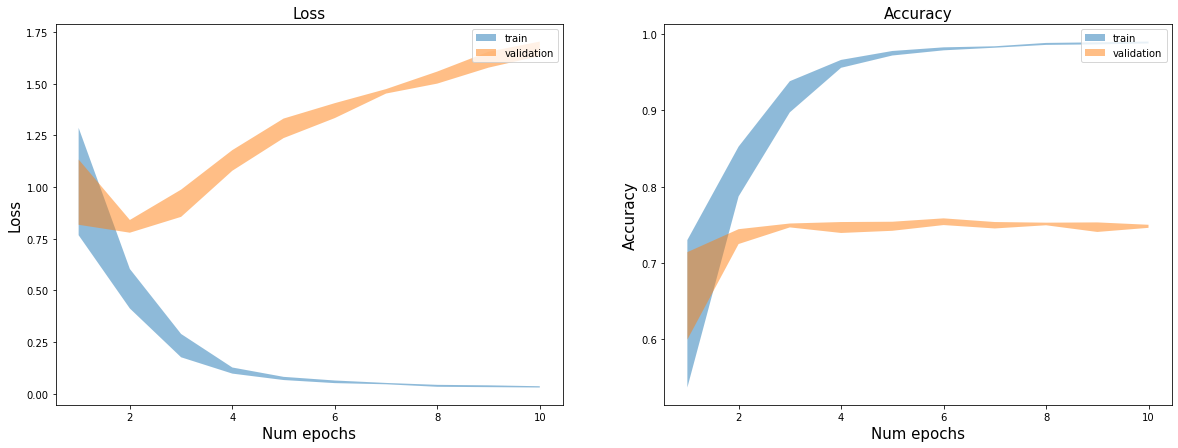

In [15]:
NUM_CLASSES = 10
DEVICE = 'cuda'
NUM_EPOCHS = 10
RUN_SIZES = 4
LR = 1e-3
CRITERION = torch.nn.CrossEntropyLoss()

teacher = SimpleConvNet(num_classes = NUM_CLASSES).to(DEVICE)
teacher_optimizer = torch.optim.Adam(teacher.parameters(),lr=LR)
teacher, history_teacher = train_teacher(NUM_EPOCHS,RUN_SIZES,teacher,teacher_optimizer,
                                        train_loader,val_loader, CRITERION, DEVICE )

In [20]:
hist_teach = history_teacher 

In [21]:
teacher_trained = teacher
history_teacher_trained = history_teacher

In [18]:
def train_student_hinton(*args, **kwargs):
    
    history = defaultdict(lambda: defaultdict(list))
    for epoch in tqdm_notebook(range(kwargs['num_epochs'])):
        
        start_time = time.time()
        
        train_loss_list = []
        train_acc_list =  []
        val_loss_list  =  []
        val_acc_list   =  []
        
      
        
        for run_size in tqdm_notebook(range(kwargs['run_sizes'])):
            
            train_loss = 0
            train_acc = 0
            val_loss = 0
            val_acc = 0
            
            kwargs['student'].requires_grad_(True)
            kwargs['teacher'].requires_grad_(False)
        
            for x_batch,y_batch in tqdm_notebook(kwargs['train_loader']):
                x_batch,y_batch = x_batch.to(kwargs['device']), y_batch.to(kwargs['device'])
            
                kwargs['student_optimizer'].zero_grad()
            
                logits_teacher = kwargs['teacher'](x_batch).detach()
                logits_student = kwargs['student'](x_batch)
            
                loss_student = kwargs['criterion'](logits_student, y_batch.long().to(kwargs['device']))
            
                distillation_loss = torch.nn.KLDivLoss(reduction = 'none')(torch.nn.Softmax(dim=1)\
                                (logits_student/kwargs['temperature']) , torch.nn.Softmax(dim=1)\
                                (logits_teacher/kwargs['temperature'])).sum(1).mean()
            
                full_loss = 1*loss_student + 0.1*distillation_loss
                full_loss.backward()
                kwargs['student_optimizer'].step()
            
                train_loss += np.sum(full_loss.detach().cpu().numpy())
                y_pred = logits_student.max(1)[1].detach().cpu().numpy()
                train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        
            train_loss /= len(kwargs['train_loader'])
            train_acc /=  len(kwargs['train_loader'])
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            
            
            
             
        
            kwargs['student'].requires_grad_(False)
        
            with torch.no_grad():
                for x_batch,y_batch in tqdm_notebook(kwargs['val_loader']):
                    x_batch,y_batch = x_batch.to(kwargs['device']),y_batch.to(kwargs['device'])
                
                    logits_student = kwargs['student'](x_batch).detach()
                    logits_teacher =  kwargs['teacher'](x_batch).detach()
                
                    loss_student = kwargs['criterion'](logits_student, y_batch.long().to(kwargs['device']))
                    distillation_loss = torch.nn.KLDivLoss(reduction = 'none')(torch.nn.Softmax(dim=1)\
                                (logits_student/kwargs['temperature']) , torch.nn.Softmax(dim=1)\
                                (logits_teacher/kwargs['temperature'])).sum(1).mean()
                
                    full_loss_val = 1*loss_student + 0.1*distillation_loss
                    val_loss += np.sum(full_loss_val.detach().cpu().numpy())
                    y_pred = logits_student.max(1)[1].detach().cpu().numpy()
                    val_acc += np.mean(y_batch.cpu().numpy() == y_pred )
            
                val_loss /= len(kwargs['val_loader'])
                val_acc /= len(kwargs['val_loader'])
                val_loss_list.append(val_loss)
                val_acc_list.append(val_acc)
                
                
        history['loss']['val'].append(val_loss_list)
        history['acc']['val'].append(val_acc_list)
        history['loss']['train'].append(train_loss_list)
        history['acc']['train'].append(train_acc_list)
            
        clear_output()
            
        print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, kwargs['num_epochs'], time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history,epoch)
        
        
    return kwargs['student'], history

Epoch 10 of 10 took 80.791s
  training loss (in-iteration): 	-0.084034
  validation loss (in-iteration): 	1.776633
  training accuracy: 			98.98 %
  validation accuracy: 			75.16 %


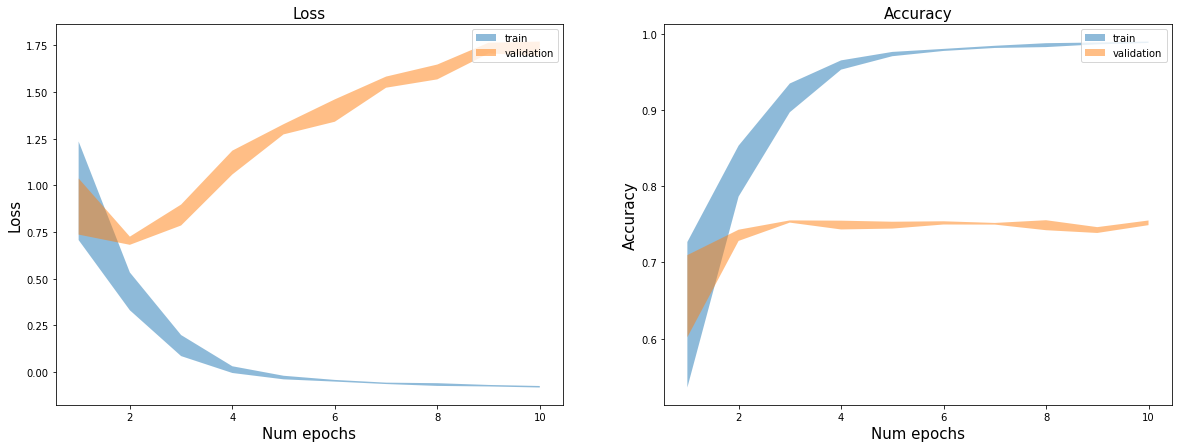

In [19]:
NUM_EPOCHS = 10
RUN_SIZES = 4
TEMPERATURE = 3
NUM_CLASSES = 10

DEVICE = 'cuda'
LR = 1e-3
student = SimpleConvNet(NUM_CLASSES).to(DEVICE)
student_optimizer = torch.optim.Adam(student.parameters(),lr=LR)
trained_teacher = teacher
CRITERION = torch.nn.CrossEntropyLoss()


student, history_student = train_student_hinton(num_epochs = NUM_EPOCHS,run_sizes = RUN_SIZES, student = student , teacher = trained_teacher,
                                        device = DEVICE, train_loader = train_loader, val_loader = val_loader,
                                        student_optimizer = student_optimizer, criterion = CRITERION, temperature = TEMPERATURE)

In [22]:
student_trained = student
history_student_trained = history_student

In [27]:
def train_student_hinton_modified(*args, **kwargs):
    
    history = defaultdict(lambda: defaultdict(list))
    for epoch in tqdm_notebook(range(kwargs['num_epochs'])):
        
        start_time = time.time()
        
        train_loss_list = []
        train_acc_list =  []
        val_loss_list  =  []
        val_acc_list   =  []
        
        for run_size in tqdm_notebook(range(kwargs['run_sizes'])):
            
            train_loss = 0
            train_acc = 0
            val_loss = 0
            val_acc = 0
        
            kwargs['student'].requires_grad_(True)
            kwargs['teacher'].requires_grad_(False)
        
            for x_batch,y_batch in tqdm_notebook(kwargs['train_loader']):
                x_batch,y_batch = x_batch.to(kwargs['device']), y_batch.to(kwargs['device'])
            
                kwargs['student_optimizer'].zero_grad()
            
                logits_teacher = kwargs['teacher'](x_batch).detach()
                logits_student = kwargs['student'](x_batch)
            
                loss_student = kwargs['criterion'](logits_student, y_batch.long().to(kwargs['device']))
            
                distillation_loss = torch.nn.KLDivLoss(reduction = 'none')(torch.nn.Softmax(dim=1)\
                                (logits_student/kwargs['temperature']) , torch.nn.Softmax(dim=1)\
                                (logits_teacher/kwargs['temperature'])).sum(1).mean()
            
            # parameters loss
                param_loss = torch.tensor([0.]).cuda()
                for (name_student, param_student),(name_teacher, param_teacher) in zip(kwargs['student'].named_parameters(),
                                                                                  kwargs['teacher'].named_parameters()):
                    if param_student.requires_grad:
                        param_loss += torch.norm( param_student.data - param_teacher.data )
                    
            
                full_loss = 1*loss_student + 0.1*distillation_loss + 0.0005*param_loss # (1e-5 : 1e-7)
                full_loss.backward()
                kwargs['student_optimizer'].step()
            
                train_loss += np.sum(full_loss.detach().cpu().numpy())
                y_pred = logits_student.max(1)[1].detach().cpu().numpy()
                train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        
            train_loss /= len(kwargs['train_loader'])
            train_acc /=  len(kwargs['train_loader'])
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
        
            kwargs['student'].requires_grad_(False)
        
            with torch.no_grad():
                for x_batch,y_batch in tqdm_notebook(kwargs['val_loader']):
                    x_batch,y_batch = x_batch.to(kwargs['device']),y_batch.to(kwargs['device'])
                
                    logits_student = kwargs['student'](x_batch).detach()
                    logits_teacher =  kwargs['teacher'](x_batch).detach()
                
                    loss_student = kwargs['criterion'](logits_student, y_batch.long().to(kwargs['device']))
                    distillation_loss = torch.nn.KLDivLoss(reduction = 'none')(torch.nn.Softmax(dim=1)\
                                (logits_student/kwargs['temperature']) , torch.nn.Softmax(dim=1)\
                                (logits_teacher/kwargs['temperature'])).sum(1).mean()
                
                # parameters loss
                    param_loss = torch.tensor([0.]).cuda()
                    for (name_student,param_student),(name_teacher, param_teacher) in zip(kwargs['student'].named_parameters(),
                                                                                     kwargs['teacher'].named_parameters()):
                        if 'linear' in name_student:
                            param_loss += torch.norm(param_student.data - param_teacher.data)
                        
                
                
                
                    full_loss_val = 1*loss_student + 0.2*distillation_loss + 0.0005*param_loss
                
                    val_loss += np.sum(full_loss_val.detach().cpu().numpy())
                    y_pred = logits_student.max(1)[1].detach().cpu().numpy()
                    val_acc += np.mean(y_batch.cpu().numpy() == y_pred )
            
                val_loss /= len(kwargs['val_loader'])
                val_acc /= len(kwargs['val_loader'])
                val_loss_list.append(val_loss)
                val_acc_list.append(val_acc)
                
        
        history['loss']['train'].append(train_loss_list)
        history['acc']['train'].append(train_acc_list)
        history['loss']['val'].append(val_loss_list)
        history['acc']['val'].append(val_acc_list)
        
    
        clear_output()
            
        print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, kwargs['num_epochs'], time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history, epoch)
        
    return kwargs['student'], history
        

Epoch 10 of 10 took 87.794s
  training loss (in-iteration): 	0.249153
  validation loss (in-iteration): 	1.699111
  training accuracy: 			98.95 %
  validation accuracy: 			75.26 %


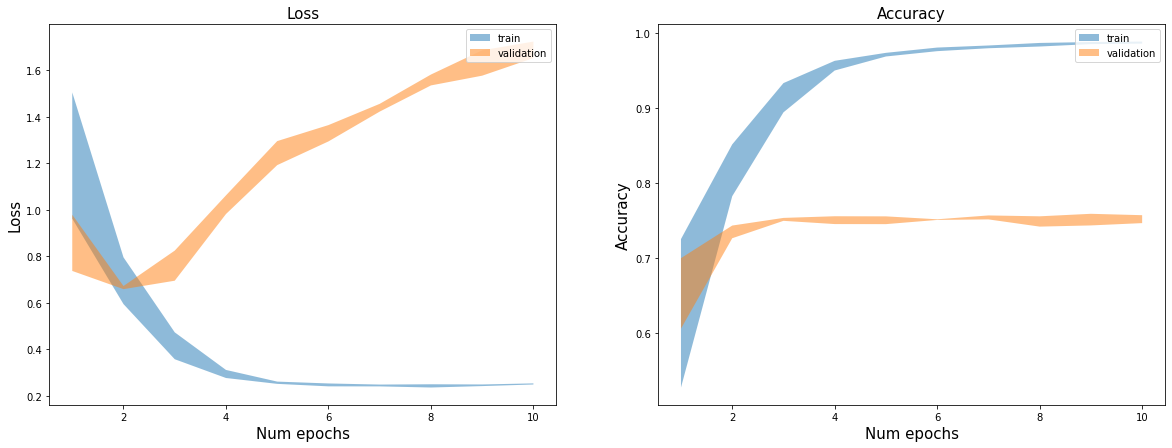

In [28]:
NUM_EPOCHS = 10
RUN_SIZES = 4
TEMPERATURE = 3
NUM_CLASSES = 10

DEVICE = 'cuda'
LR = 1e-3
student = SimpleConvNet(NUM_CLASSES).to(DEVICE)
student_optimizer = torch.optim.Adam(student.parameters(),lr=LR)
trained_teacher = teacher
CRITERION = torch.nn.CrossEntropyLoss()


student, history_student = train_student_hinton_modified(num_epochs = NUM_EPOCHS,run_sizes = RUN_SIZES, student = student , teacher = teacher,
                                        device = DEVICE, train_loader = train_loader, val_loader = val_loader,
                                        student_optimizer = student_optimizer, criterion = CRITERION, temperature = TEMPERATURE)

In [30]:
def plot_learning_accuracy(history, num_epoch, color,label):
    '''
     
    This function is aimed to show up at all loss and accuracy (metrics) during the training of the model

    :param history: (dict)
        accuracy and loss on the training and validation
    '''
    # sns.set_style(style='whitegrid')

    fig,ax = plt.subplots(1,1,figsize=(20, 7))
    plt.title('Accuracy', fontsize=15)
    
    #ax = ax.flatten()
    ax.fill_between(np.arange(1,num_epoch + 2),(np.mean(history[0]['acc']['val'],axis=1) - np.std(history[0]['acc']['val'],axis=1)),\
                     (np.mean(history[0]['acc']['val'],axis=1) + np.std(history[0]['acc']['val'],axis=1)), color = color[0], label=label[0],alpha=.5)
    
    ax.fill_between(np.arange(1,num_epoch + 2),(np.mean(history[1]['acc']['val'],axis=1) - np.std(history[1]['acc']['val'],axis=1)),\
                     (np.mean(history[1]['acc']['val'],axis=1) + np.std(history[1]['acc']['val'],axis=1)), color = color[1], label=label[1],alpha=.5)
    
    ax.fill_between(np.arange(1,num_epoch + 2),(np.mean(history[2]['acc']['val'],axis=1) - np.std(history[2]['acc']['val'],axis=1)),\
                     (np.mean(history[2]['acc']['val'],axis=1) + np.std(history[2]['acc']['val'],axis=1)), color = color[2], label=label[2],alpha=.5)
    

    
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()
    plt.show()

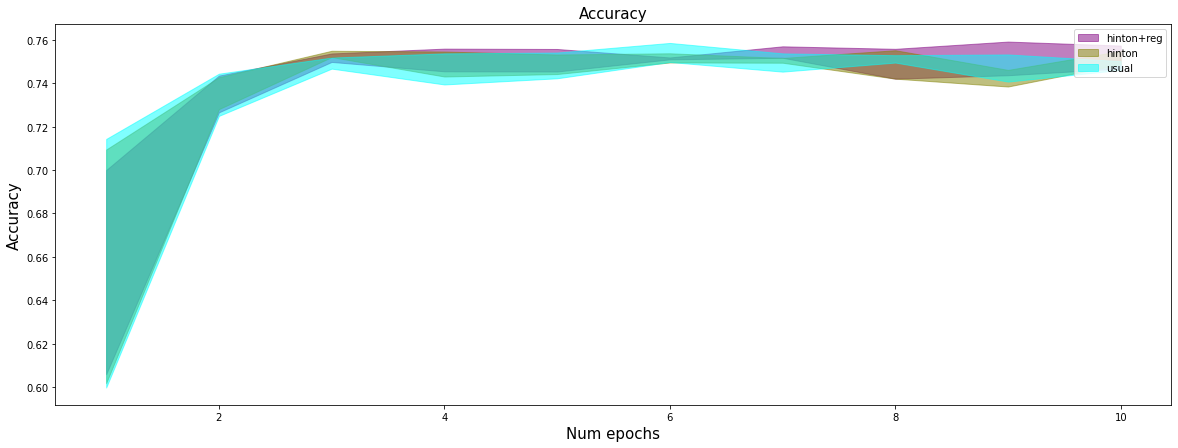

In [32]:
plot_learning_accuracy([history_student,history_student_trained,history_teacher_trained],9,['purple','olive','cyan'],['hinton+reg','hinton','usual'])